#   **INTRODUCTION** 
In this work We tried to implement Knowledge Distillation(KD) technique as proposed by Geofrey Hinton in thier paper titled  "Distilling the Knowledge in a Neural Network" the technique was adopted in our paper called Lighweight Plant Disease Detection Model for Embedded Device with the aim of achieving a lighter CNN model for plant disease detection.
* **Goal**: 
Our aim is to developed a deep learning model that will aid African farmers in detecting diseases that are affecting thier crops using thier smartphones.the start of the art CNN models are not suitable for deployment on smartphones due to thier sizes and huge number of parametres. We therefore, compressed the model using KD to reduce model parameters while keeping the performance. we use open source plant disease detection dataset organized by PlantVIllage to train and validate our model.
* **Contribution:** 
To obtain a lighweight model that will be suitable for deployment on embedded devices such as smartphone 

# 1- Uplaoding necessary libraries 

In [1]:
import os
import pickle
import zipfile
import random

In [2]:
import os
import pickle
import zipfile
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import image
import matplotlib.pyplot as plt

2024-03-30 19:18:51.493552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#  2- How Does Knowledge Distillation Works?


Knowledge distillation is a technique of model compression that employs teacher-student learning. In this technique, a large, cumbersome pre-trained model called the teacher model is trained first on a large dataset. The knowledge learned by the teacher model is transferred (distilled) to a shallow lightweight model called the student model, whereby the student mimics the performance of the teacher model despite its shallow nature. The student model size is relatively reduced without sacrificing accuracy. Figure.1 presents the architecture of the knowledge distillation technique.  
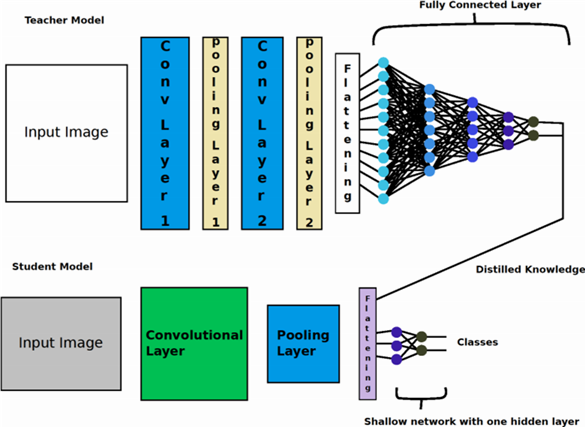

# 3- Creating Distiller Class 

## Construct `Distiller()` class

This custom class`Distiller()` was used to overrides the  original Model methods namely:`train_step`, `test_step`,
and `compile()`.
* **Train_step:** A training step is one gradient update. In one step batch_size many examples are processed. An epoch consists of one full cycle through the training data. This is usually many steps. As an example, if you have 2,000 images and use a batch size of 10 an epoch consists of 2,000 images / (10 images / step) = 200 steps
* **Compile method:** It specifies a loss, metrics, and an optimizer. To train a model with fit(), you need to specify a loss function, an optimizer, and optionally, some metrics to monitor. We can pass these variables to the model as arguments to the compile() method. 

In order to use the distiller, we need:

- A trained teacher model
- A student model to train
- A student loss function on the difference between student predictions and ground-truth
- A distillation loss function, along with a `temperature`, on the difference between the
soft student predictions and the soft teacher labels
- An `alpha` factor to weight the student and distillation loss
- An optimizer for the student and (optional) metrics to evaluate performance

In the `train_step` method, we perform a forward pass of both the teacher and student,
calculate the loss with weighting of the `student_loss` and `distillation_loss` by `alpha` and
`1 - alpha`, respectively, and perform the backward pass. Note: only the student weights are updated,
and therefore we only calculate the gradients for the student weights.

In the `test_step` method, we evaluate the student model on the provided dataset.

In [3]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results
    def call(self, data, training=False): 
        # You don't need this method for training.
        # So just pass.
        pass
        

In [ ]:
import splitfolders
splitfolders.ratio('/Users/yashicadhalla/Desktop/mnor/plantvillage dataset/color', output="output", seed=1337, ratio=(.8, 0.1,0.1))

# 4- Flowing Images from directory


In step 4, the traning and validation datasets are flown from the directory to a variables called train_generator and validation_genearator. we also specify the batch size and resize all the images to 250 by 250px.

In [6]:
TRAINING_DIR = "./output/train"
train_datagen = ImageDataGenerator(rescale=1.0/255
                
               )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    batch_size=40,
                                                    target_size=(250, 250))

VALIDATION_DIR = "./output/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              class_mode='categorical',
                                                              batch_size=40,
                                                              target_size=(250, 250))

Found 43429 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.


In [24]:
TRAINING_DIR = "./output/train"
train_datagen = ImageDataGenerator(rescale=1.0/255
                
               )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    batch_size=500,
                                                    target_size=(250, 250))

VALIDATION_DIR = "./output/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              class_mode='categorical',
                                                              batch_size=500,
                                                              target_size=(250, 250))

Found 43429 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.


## Sample Images From the Dataset


The code below defines a method plotImages which defined how to  plot sample images from the dataset using matplotlib library and imshow() method.  The Imagedatagenerator output array train_generator was used as input array to the method and then  five images  were selected from it.

In [47]:
%conda install pillow

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


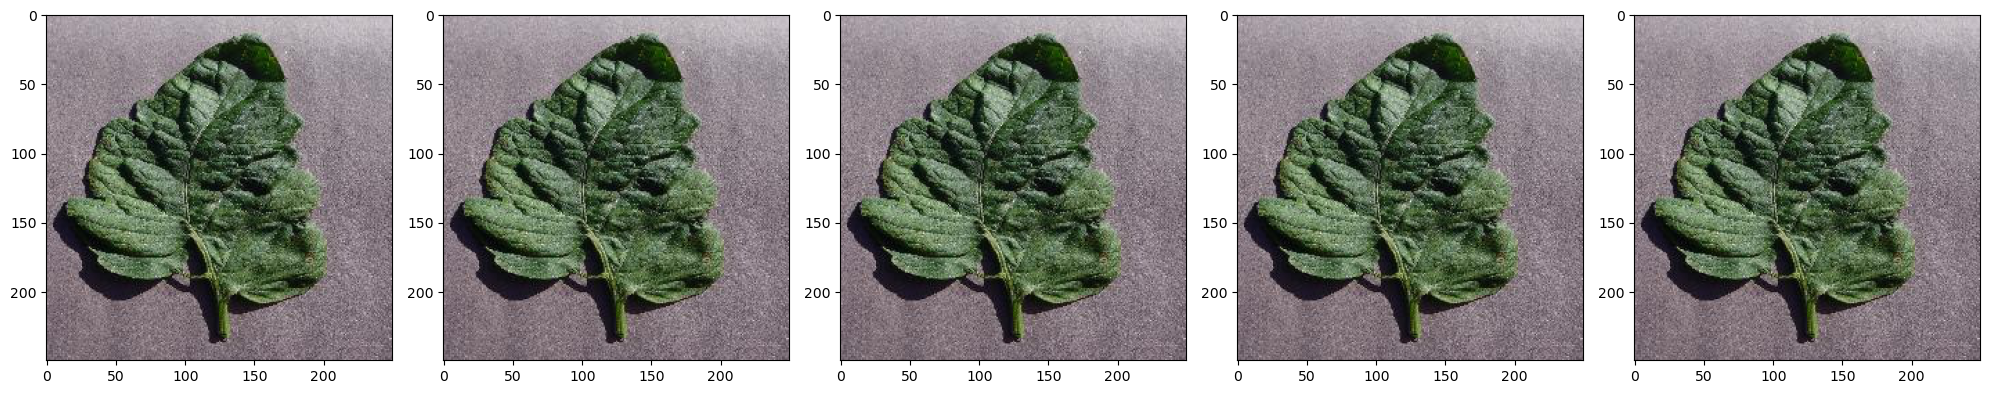

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# 5- Getting Categorical Labels
We obtained the the labels associated with each images that is all the directories name from our dataset and assign it to a varaible called train_y 

In [8]:
train_y=train_generator.classes


# 6- Converting categorical labels to binary otherwise called (Encoding)
Label Binarizer is an SciKit Learn class that accepts Categorical data as input and returns an Numpy array. Unlike Label Encoder, it encodes the data into dummy variables indicating the presence of a particular label or not. Encoding make column data using Label Binarizer

In [10]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(train_y)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

# 7- Create student and teacher models

Initialy, we create a teacher model and a smaller student model using keras. Both models are
convolutional neural networks and created using `Sequential()`,
but could be any Keras model.

In [11]:

# Create the teacher model 
teacher = keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_shape=(250, 250, 3)
)
# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(250, 250, 3)),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(n_classes),
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

2024-03-30 19:20:34.687568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Add global average pooling and dense layers for classification
x = layers.GlobalAveragePooling2D()(teacher.output)
output = layers.Dense(n_classes, activation='softmax')(x)

# Create the teacher model
teacher_model = keras.Model(inputs=teacher.input, outputs=output)

# 8- Displaying the model summary
the custom method 'summary' allows us to diplay the architecture of the models described above, this allows us to know thw number parameters avaible in our defined model.

In [13]:
teacher_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [22]:
student_m.summary()

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 128)        0   

# 9- Compiling Teacher Model for training
The teacher model is first compile using custom compile method to achieve better accucaracy and learn more information

In [15]:
# Train teacher as usual
teacher_model.compile(
    optimizer=keras.optimizers.legacy.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'],
)


# 10- Train the teacher


In [16]:
teacher_history=teacher_model.fit(train_generator, validation_data=validation_generator, epochs=5)

Epoch 1/5


/Users/yashicadhalla/opt/anaconda3/envs/myv/lib/python3.10/site-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1086/1086 [==============================] - 79640s 73s/step - loss: 0.2807 - acc: 0.9169 - val_loss: 0.7046 - val_acc: 0.7990
Epoch 2/5
1086/1086 [==============================] - 94458s 87s/step - loss: 0.0965 - acc: 0.9681 - val_loss: 0.7734 - val_acc: 0.8099
Epoch 3/5
1086/1086 [==============================] - 33670s 31s/step - loss: 0.0604 - acc: 0.9799 - val_loss: 0.2610 - val_acc: 0.9232
Epoch 4/5
1086/1086 [==============================] - 26846s 25s/step - loss: 0.0523 - acc: 0.9832 - val_loss: 0.6276 - val_acc: 0.8393
Epoch 5/5
1086/1086 [==============================] - 34849s 32s/step - loss: 0.0434 - acc: 0.9858 - val_loss: 0.6624 - val_acc: 0.8315


In [ ]:
teacher_predictions = teacher_model.predict(validation_generator)

# 11- Plotting Teacher Model Accuracy and loss Curves
* **Accruacy curve:** The accuracy curve describes the accuracy of test and validation sets. The X-axis is the iteration step. The Y-axis is the prediction accuracy. The blue curve is the accuracy on a batch of training examples from the training set, the orange curve is the accuracy for the test set.
* **Loss curve:** One of the most used plots to debug a neural network is a Loss curve during training. It gives us a snapshot of the training process and the direction in which the network learns

range(1, 6)


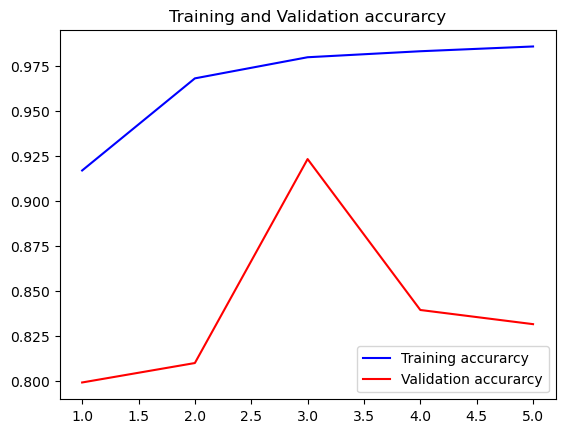

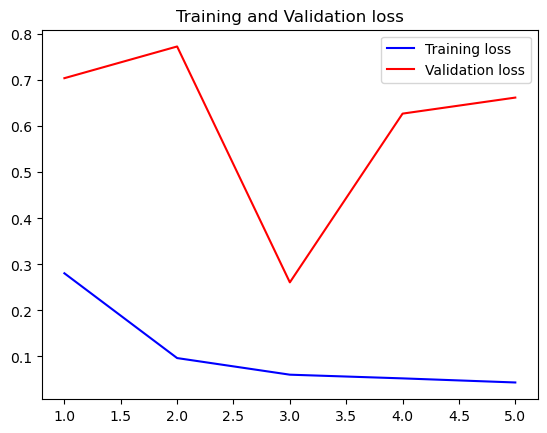

In [17]:
import matplotlib.pyplot as plt
acc = teacher_history.history['acc']
val_acc = teacher_history.history['val_acc']
loss = teacher_history.history['loss']
val_loss = teacher_history.history['val_loss']
print(range(1, len(acc) + 1))

epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()



plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# 12-Distilling teacher knowledge to student Model


We have already trained the teacher model, and we only need to initialize a
`Distiller(student, teacher)` instance, `compile()` it with the desired losses,
hyperparameters and optimizer, and distill the teacher to the student.</br>
Here we are trying to calculate the general loss by conputing KL divergence between student loss and distillation using the following relation.</br> 
Dist_loss=  1/m ∑_(j=0)^m〖(2t^2 αD_KL (p^j,q^j )-(1-α)∑_(i=1)^cyi〗^(j  )  log⁡(1-〖yhat〗^j)〗</br>

where: </br>
P: is the soft labels from the teacher network</br>
q: is the softmax scores of student model</br>
Dkl: is the Kullback- Liebler (KL) divergence between p and q </br>
α: is the relative importance of the teacher’s guidance </br>
The distillation loss was minimized using the KL divergence between soft labels of a teacher p, and student model score q



In [32]:

# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher_model)
distiller.compile(optimizer=keras.optimizers.legacy.Adam(), metrics=['acc'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),alpha=0.1,temperature=10,)

# Distill teacher to student
student_history=distiller.fit(train_generator, validation_data=validation_generator, epochs=8)

Epoch 1/8
87/87 [==============================] - 71289s 828s/step - acc: 0.5023 - student_loss: 1.9086 - distillation_loss: 0.0152 - val_acc: 0.7278 - val_student_loss: 1.0853
Epoch 2/8
87/87 [==============================] - 10599s 122s/step - acc: 0.7709 - student_loss: 0.8954 - distillation_loss: 0.0222 - val_acc: 0.7954 - val_student_loss: 0.7819
Epoch 3/8
87/87 [==============================] - 8256s 95s/step - acc: 0.8361 - student_loss: 0.6655 - distillation_loss: 0.0226 - val_acc: 0.8265 - val_student_loss: 0.7354
Epoch 4/8
87/87 [==============================] - 7547s 87s/step - acc: 0.8711 - student_loss: 0.5521 - distillation_loss: 0.0222 - val_acc: 0.8491 - val_student_loss: 0.6124
Epoch 5/8
87/87 [==============================] - 32039s 372s/step - acc: 0.8994 - student_loss: 0.4654 - distillation_loss: 0.0218 - val_acc: 0.8606 - val_student_loss: 0.5630
Epoch 6/8
87/87 [==============================] - 14072s 163s/step - acc: 0.9187 - student_loss: 0.4028 - distill

## Plotting Student model Accuracy and loss curves
to investigate the performance of the student model for comparison with teacher model, an accaucry and validation curve was plotted below.

range(1, 6)


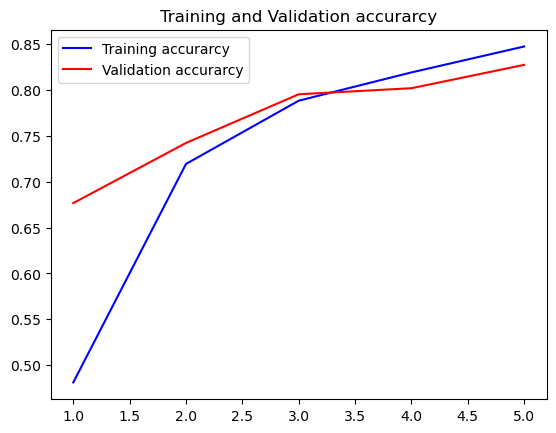

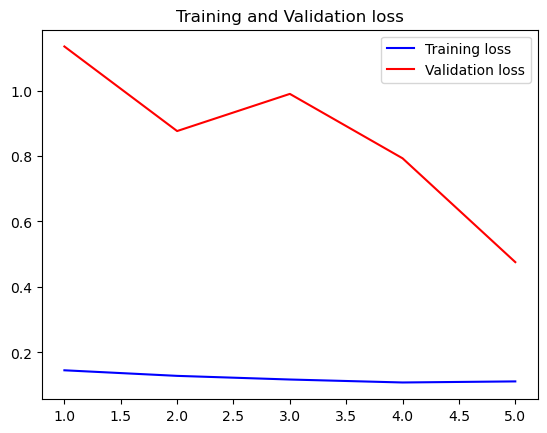

In [26]:
import matplotlib.pyplot as plt
acc = student_history.history['acc']
val_acc =student_history.history['val_acc']
loss = student_history.history['distillation_loss']
val_loss = student_history.history['student_loss']
print(range(1, len(acc) + 1))

epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()



plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## Train student from scratch for comparison

We can also train an equivalent student model from scratch without the teacher, in order
to evaluate the performance gain obtained by knowledge distillation.

In [ ]:
# Train student as doen usually
student_scratch.compile(
    optimizer=keras.optimizers.legacy.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'],
)

# Train and evaluate student trained from scratch.
student_scratch.fit(train_generator, epochs=1)
std_history=student_scratch.evaluate(validation_generator)

# 13 Conclusion
In conclusion, it can be seen that that teacher model was having over 52M parametres, while the student model was just having a little above 1M  parameters. this makes our proposed student model suitable for deployment on embeded device.  the inresting thing about this work is that the performance of the student is somewhat similar to that  of teacher model.
*  If the teacher is trained for 10 full epochs and the student is distilled on this teacher
for 5 full epochs, you should in this example experience a performance boost compared to
training the same student model from scratch, and even compared to the teacher itself.
You should expect the teacher to have accuracy around 97.6%, the student trained from
scratch should be around 96%, and the distilled student should be around 98.1%. Remove
or try out different seeds to use different weight initializations, This performances may change depending on the stochastic nature of the environmental setup.